In [282]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import random
import math

In [283]:
#load data from csv file

def loadCsv(filename):
    #TODO choose collums by indices and not by string name
    df = pd.read_csv(filename, usecols=['Rel_BreitGross', 'RelSpitze_oben',
                     'RelSpitze_unten', 'Anzahl_Linie', 'Anzahl_Kreis','Anzahl_Ecken', 'Label'])
    """
    dataset = df.values.tolist()
    
    for i in range(len(dataset)):
        dataset[i] = [float(x) for x in dataset[i]]
    """
    return df

dataset=loadCsv('ricsData2.csv')
dataset.head()

,Rel_BreitGross,RelSpitze_oben,RelSpitze_unten,Anzahl_Linie,Anzahl_Ecken,Anzahl_Kreis,Label
0,0.585379,0.703125,0.796875,0,2,0,0
1,0.359746,0.986014,0.972028,0,2,0,0
2,0.440901,0.201531,0.994898,0,2,0,0
3,0.456432,0.182278,0.643038,0,1,0,0
4,0.409339,0.840426,0.837766,0,1,0,0


<AxesSubplot:>

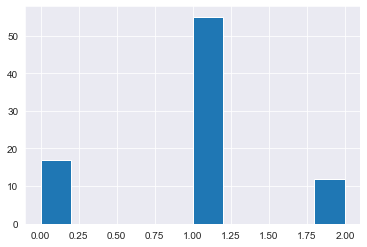

In [284]:
dataset["Label"].hist()

<AxesSubplot:>

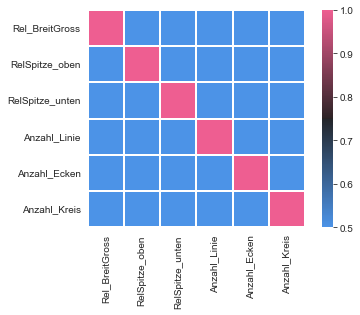

In [285]:
#Check if the features are independent 
corr = dataset.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr,vmax=1,vmin=0.5,cmap=cmap,square=True,linewidths=0.2)

In [286]:
#print all features 
for col in dataset.columns:
    print(col)

Rel_BreitGross
RelSpitze_oben
RelSpitze_unten
Anzahl_Linie
Anzahl_Ecken
Anzahl_Kreis
Label


In [287]:
#choose the features that are independet
choosen_dataset=dataset[['Rel_BreitGross', 'RelSpitze_oben',
                     'RelSpitze_unten', 'Anzahl_Linie', 'Anzahl_Kreis','Anzahl_Ecken','Label']]

choosen_dataset.head()


,Rel_BreitGross,RelSpitze_oben,RelSpitze_unten,Anzahl_Linie,Anzahl_Kreis,Anzahl_Ecken,Label
0,0.585379,0.703125,0.796875,0,0,2,0
1,0.359746,0.986014,0.972028,0,0,2,0
2,0.440901,0.201531,0.994898,0,0,2,0
3,0.456432,0.182278,0.643038,0,0,1,0
4,0.409339,0.840426,0.837766,0,0,1,0


<AxesSubplot:xlabel='Anzahl_Ecken', ylabel='Count'>

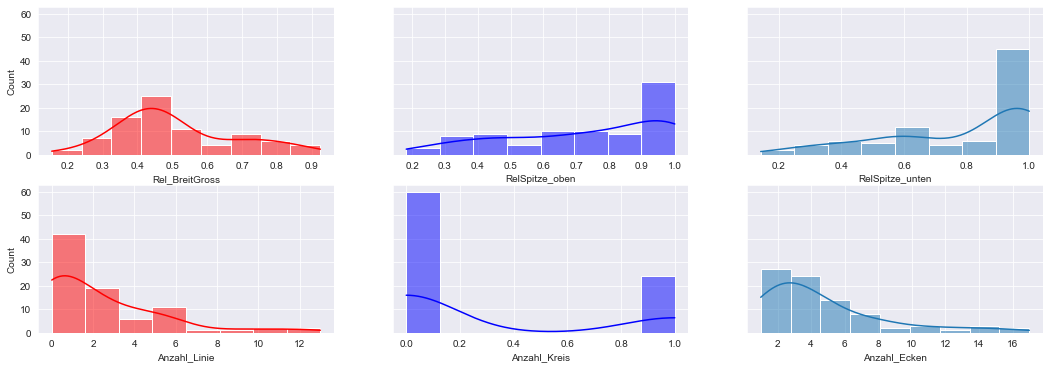

In [288]:
#accorodingly to the choosen date change the name of the x values 

fig, axes = plt.subplots(2, 3, figsize=(18, 6), sharey=True)
sns.histplot(choosen_dataset, ax=axes[0][0], x="Rel_BreitGross", kde=True, color='r')
sns.histplot(choosen_dataset, ax=axes[0][1], x="RelSpitze_oben", kde=True, color='b')
sns.histplot(choosen_dataset, ax=axes[0][2], x="RelSpitze_unten", kde=True)
sns.histplot(choosen_dataset, ax=axes[1][0], x="Anzahl_Linie", kde=True, color='r')
sns.histplot(choosen_dataset, ax=axes[1][1], x="Anzahl_Kreis", kde=True, color='b')
sns.histplot(choosen_dataset, ax=axes[1][2], x="Anzahl_Ecken", kde=True)

In [289]:
def splitDataset(df, splitRatio):
    
    dataset=df.values.tolist()#only use this line if the data is not in list format 
    trainSize = int(len(dataset)*splitRatio)
    trainSet = []
    copy = list(dataset)
    while len(trainSet) < trainSize:
        index = random.randrange(len(copy))
        trainSet.append(copy.pop(index))
    return [trainSet,copy]


In [290]:
def separateByClass(dataset):
    separated = {}
    for i in range(len(dataset)):
        vector = dataset [i]
        if (vector[-1] not in separated):
            separated[vector[-1]]=[]
        separated[vector[-1]].append(vector)
    return separated
            

In [291]:
def mean(numbers):
    return sum(numbers)/float(len(numbers))

In [292]:
def stdev(numbers):
    avg = mean (numbers)
    variance = sum ([pow(x-avg,2) for x in numbers])/float(len(numbers)-1)
    return math.sqrt(variance)

In [293]:
def summarize(dataset):
    summaries =[(mean(attribute),stdev(attribute))for attribute in zip(*dataset) ]
    del summaries[-1]
    return summaries

In [294]:
def summarizeByClass(dataset):
    separated = separateByClass(dataset)
    summaries = {}
    for classValue, instances in separated.items():
        summaries[classValue]= summarize(instances)
    return summaries 

In [295]:
def calculateProbability(x,mean,stdev):
    exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
    return (1/(math.sqrt(2*math.pi)*stdev))*exponent

In [296]:
def calculateClassProbabilities(summaries, inputVector):
    probabilities = {}
    for classValue, classSummaries in summaries.items():
        probabilities[classValue]= 1
        for i in range(len(classSummaries)):
            mean,stdev = classSummaries[i]
            x = inputVector[i]
            probabilities[classValue] *= calculateProbability(x,mean,stdev)
        return probabilities

In [297]:
def predict(summaries, inputVector):
    probabilities = calculateClassProbabilities(summaries,inputVector)
    bestLabel,bestProb = None, -1 
    for classValue, probability in probabilities.items():
        if bestLabel is None or probability > bestProb:
            bestProb = probability
            bestLabel = classValue
    return bestLabel

In [298]:
def getPredictions(summaries, testSet):
    predictions =[]
    for i in range(len(testSet)):
        result = predict(summaries,testSet[i])
        predictions.append(result)
    return predictions
      

In [299]:
def getAccuracy(testSet, predictions):
    correct=0
    for x in range(len(testSet)):
        if testSet[x][-1]==predictions[x]:
            correct += 1
    return (correct/float(len(testSet)))*100.0


In [300]:
def main():
    #filename = 'ric.csv'
    splitRatio = 0.8 
    #datset=loadCsv(filename)
    trainingSet,testSet = splitDataset(choosen_dataset,splitRatio)
    print('Split {0} rows into train ={1} and test = {2} rows'.format(len(choosen_dataset),len(trainingSet),len(testSet)))
    #prepare model
    summaries = summarizeByClass(trainingSet)
    #test model
    predictions = getPredictions (summaries, testSet)
    accuracy = getAccuracy(testSet,predictions)
    print('Acucuracy: {0}%'.format(accuracy))
    

In [301]:
main()

Split 84 rows into train =67 and test = 17 rows
Acucuracy: 58.82352941176471%
